# Исследование продуктовых метрик по данным продаж онлайн магазина.

Источник данных: учебная база данных Northwind

Цель: Рассчитать и исследовать продуктовые метрики с помощью sql-запросов и библиотеки pandas для анализа пользовательского поведения. 

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from urllib.parse import quote
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# параметры подключения
username = "student"
password = "123456sql@"
host = "rc1b-cpsjckr2wfkuk61s.mdb.yandexcloud.net"
port = "6432"
database = "Northwind"

# Кодируем пароль
encoded_password = quote(password)
print(encoded_password)

# Формируем строку подключения
connection_string = f'postgresql+psycopg2://{username}:{encoded_password}@{host}:{port}/{database}'
engine = create_engine(connection_string)

123456sql%40


## Анализ метрик по дате создания заказа в недельном разрезе

Исследуем метрики: Gross Merchandise Value (GMV), Количество уникальных заказов (orders_created) и количество активных покупателей (active_customers_created). Метрики рассчитываются по дате создания заказа. 

Подготовка датасета

In [9]:
query = """
    select date(date_created) as date_created,
           sum(od.quantity * od.price) as gmv_created,
           count(distinct o.order_id) as orders_created,
           count(distinct o.customer_id) as active_customers_created
    from sandbox.orders o join sandbox.order_details od on o.order_id = od.order_id
    group by date(date_created)
"""
df = pd.read_sql_query(query, engine)
df.head(3)

,date_created,gmv_created,orders_created,active_customers_created
0,2017-01-05,396.90,32,18
1,2017-01-06,916.38,4,4
2,2017-01-07,1351.90,4,4


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557 entries, 0 to 556
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date_created              557 non-null    object 
 1   gmv_created               557 non-null    float64
 2   orders_created            557 non-null    int64  
 3   active_customers_created  557 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 17.5+ KB


Переводим дату в формат datetime и добавляем столбец с разбивкой в формате недели.

In [11]:
df['date_created'] = df.date_created.astype('datetime64[ns]')
df['week_created'] = df.date_created.dt.to_period('W').dt.to_timestamp()
df.head(3)

,date_created,gmv_created,orders_created,active_customers_created,week_created
0,2017-01-05,396.90,32,18,2017-01-02
1,2017-01-06,916.38,4,4,2017-01-02
2,2017-01-07,1351.90,4,4,2017-01-02


Групируем данные по неделям и считаем метрику GVM, количество заказов и количество активных пользователей по неделям.

In [15]:
df_week = df.groupby('week_created', as_index = False).agg({'gmv_created':'sum', 'orders_created':'sum', 
                                                            'active_customers_created':'sum'})
df_week.head(3)

,week_created,gmv_created,orders_created,active_customers_created
0,2017-01-02,3374.76,46,31
1,2017-01-09,11260.36,76,74
2,2017-01-16,22802.72,187,181


Добавим метрику Average Order Value (AOV) — средний чек или средняя стоимость заказа. Также рассчитаную по дате заказа.

Вопрос: Рассчет метрик AOV Created за неделю с 2017-07-10 по 2017-07-17

    select round(sum(od.quantity*od.price)/count(distinct o.order_id),1) as AOV_created
    from sandbox.orders o join order_details od on o.order_id = od.order_id
    where date_created > '2017-07-10 00:00:00' and date_created < '2017-07-17 23:59:59'
    
Ответ: 122,6    

Рассчитываем AOV для каждой недели

In [17]:
df_week['aov_created'] = df_week.gmv_created/df_week.orders_created
df_week.tail(3)

,week_created,gmv_created,orders_created,active_customers_created,aov_created
77,2018-06-25,185096.32,1388,1385,133.354697
78,2018-07-02,154628.26,1182,1179,130.819171
79,2018-07-09,154398.95,975,973,158.357897


Рассмотрим на сколько изменились метрики от недели  2018-07-09 к неделе 2018-07-02.

In [24]:
(df_week.tail(3).T[1:][79]/df_week.tail(3).T[1:][78]-1)*100

gmv_created                 -0.148298
orders_created              -17.51269
active_customers_created   -17.472434
aov_created                 21.050987
dtype: object

От недели 2018-07-09 к неделе 2018-07-02:

- GVM уменьшилась на 0.14%
- количество уникальных заказов уменьшилось на 17.5%
- количество активных пользователей также уменьшилось на 17.5%
- средний чек наоборот увеличился на 21.5%

### Рассмотрим изменение метрик в течении всего периода по недельно

In [26]:
metrics = ['gmv_created', 'aov_created', 'orders_created', 'active_customers_created']

for metric in metrics:
    df_week[f'{metric}_pct_change'] = df_week[metric].pct_change() * 100
    df_week[f'{metric}_pct_change'] = df_week[f'{metric}_pct_change'].round(1)
    
df_week.tail()

,week_created,gmv_created,orders_created,active_customers_created,aov_created,gmv_created_pct_change,aov_created_pct_change,orders_created_pct_change,active_customers_created_pct_change
75,2018-06-11,219405.76,1501,1499,146.173058,8.3,2.5,5.7,6.0
76,2018-06-18,191037.81,1442,1439,132.481144,-12.9,-9.4,-3.9,-4.0
77,2018-06-25,185096.32,1388,1385,133.354697,-3.1,0.7,-3.7,-3.8
78,2018-07-02,154628.26,1182,1179,130.819171,-16.5,-1.9,-14.8,-14.9
79,2018-07-09,154398.95,975,973,158.357897,-0.1,21.1,-17.5,-17.5


Для наглядности представим графически

C:\Users\malen\AppData\Local\Temp\ipykernel_2788\1896608438.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\malen\AppData\Local\Temp\ipykernel_2788\1896608438.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\malen\AppData\Local\Temp\ipykernel_2788\1896608438.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\malen\AppData\Local\Temp\ipykernel_2788\1896608438.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


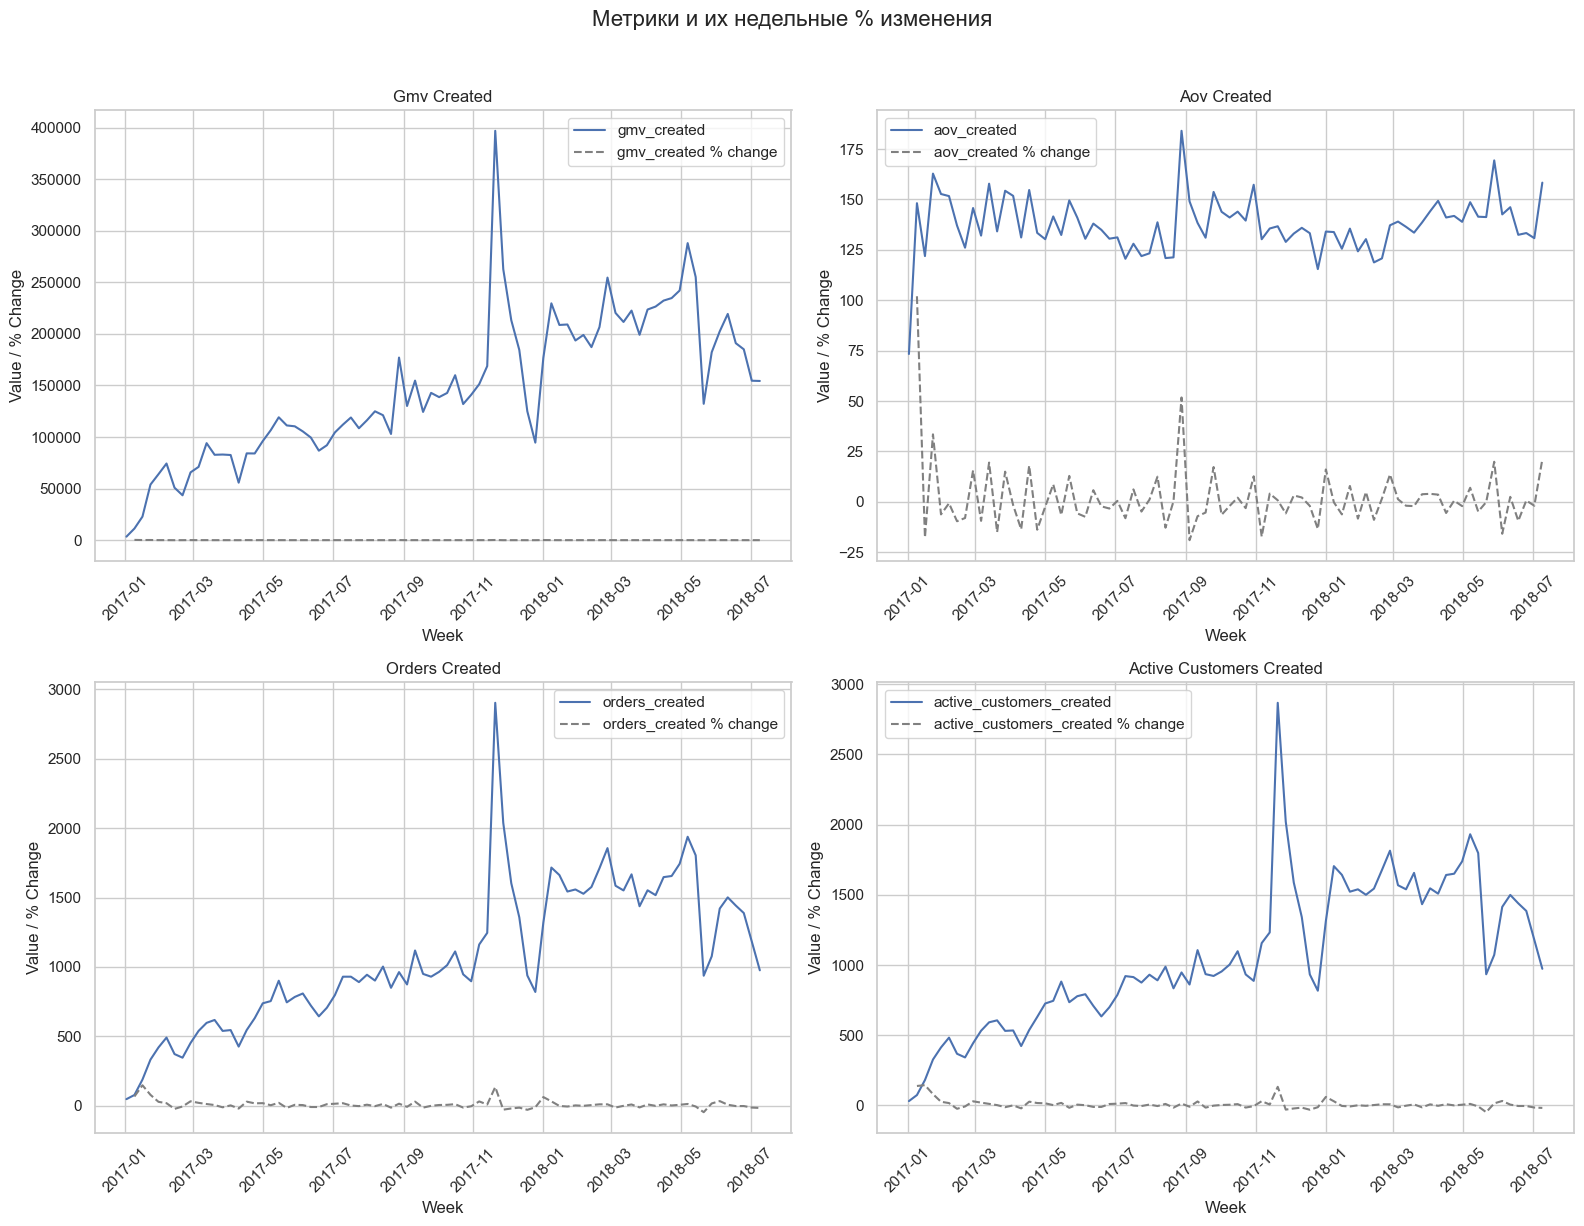

In [28]:
plt.figure(figsize=(16, 12))
sns.set(style="whitegrid")

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    sns.lineplot(data=df_week, x='week_created', y=metric, label=metric)
    
    sns.lineplot(data=df_week, x='week_created', y=f'{metric}_pct_change', 
                 label=f'{metric} % change', linestyle='--', color='gray')

    plt.xticks(rotation=45)
    plt.title(metric.replace('_', ' ').title())
    plt.ylabel('Value / % Change')
    plt.xlabel('Week')
    plt.legend()
    plt.tight_layout()

plt.suptitle('Метрики и их недельные % изменения', fontsize=16, y=1.02)
plt.tight_layout()
plt.show();

На графиках изображены четыре ключевые метрики по неделям, с наложением их недельного прироста в процентах. Ниже — анализ каждого из них:

1. GMV Created
- Основной тренд: устойчивый рост с начала 2017 года, пик в конце 2017 (~ноябрь).
- Затем стабилизация и небольшое снижение к середине 2018.
- прирост: скачкообразные колебания, особенно около пика в 2017 — вероятно, крупная акция или сезонный всплеск.

2. AOV Created (средний чек)
- Наиболее стабильная метрика: колебания в пределах 125–175 единиц.
- Прирост в % — небольшие колебания, без долгосрочного тренда.
- Это может говорить о стабильной ценовой политике или структуре заказов.

3. Orders Created
- Рост с начала 2017, резкий скачок в конце 2017, затем плавное снижение и стабилизация.
- Поведение очень похоже на GMV, что логично, так как GMV = AOV × Orders.
- % прирост — всплеск в момент в 2017 — вероятно, крупная акция или сезонный всплеск.

4. Active Customers Created
- Аналогично заказам — сильный рост до конца 2017, затем спад.
- Прирост покупателей в % минимален в 2018 — база клиентов стабилизировалась, рост замедлился.

**Общие выводы:**
- В конце 2017 был резкий рост по всем метрикам — вероятно, это связано с крупной маркетинговой кампанией, сезоном (например, Q4 активности) или запуском новой функции/продукта.
- В 2018: рост замедлился, метрики стабилизировались, приросты в % — небольшие.
- AOV — самый стабильный показатель, другие — более чувствительны к сезонности или активациям.

ARPPU (Average Revenue Per Paying User) — средний GMV на пользователя, совершившего покупку. 

Вопрос: посчитать метрику ARPPU за неделю 2017-07-10

    select round(sum(od.quantity*od.price)/count(distinct o.customer_id),1) as ARPPU
    from sandbox.orders o join order_details od on o.order_id = od.order_id
    where date_created > '2017-07-10 00:00:00' and date_created < '2017-07-17 23:59:59'

Ответ: 124

## Прибыль онлайн магазина

Прибыль онлайн магазина зависит от количества продоннаго товара и комиссии, которую устанавливает магазин для каждого вида товаров. Эта метрика рассчитывается по дате выкупа заказа. 

1. Рассчитаем метрику Margin в денежных единицах за неделю 2018-07-09. 

    select round(sum(quantity * price * commission), 1) as margin
    from sandbox.orders as o join sandbox.order_details as od on o.order_id = od.order_id
    where date_paid >= '2018-07-09 00:00:00' and date_paid < '2018-07-15 23:59:59'

    Ответ: 27864.2

2. Рассчитаем метрику Margin, % как процент Margin от GMV за неделю 2018-07-09. 

    select round((sum(quantity * price * commission)/sum(quantity * price)*100),1) as margin_persent
    from sandbox.orders as o
    inner join sandbox.order_details as od on o.order_id = od.order_id
    where date_paid >= '2018-07-09 00:00:00' and date_paid < '2018-07-15 23:59:59'

    Ответ: 26.4 %


3. Расчитаем прирост в % для метрики Margin в денежных единицах неделя 2018-07-09 к неделе 2018-07-02.

    select round((margin_cur/margin_prev - 1) * 100, 1) as margin_growth
    from (select w_date, margin as margin_prev, gmv as gmv_prev,
          lead(margin) over(order by w_date) as margin_cur
    from (select date_trunc('week', date_paid)::date as w_date,
          sum(quantity * price * commission) as margin,
          sum(quantity * price) as gmv
    from sandbox.orders as o
    inner join sandbox.order_details as od on o.order_id = od.order_id
    group by date_trunc('week', date_paid)) as t1 ) as t2
    where w_date = '2018-07-02'

    Ответ: -40,6

## Расчет метрик в разрезе категорий товаров

In [30]:
query = """
    select category_name, 
          date(date_created) as date_created,
          count(distinct o.order_id) as orders_created,
          round(sum(quantity * price),2) as gmv_created,
          count(distinct o.customer_id) as active_customers_created,
          round(sum(od.quantity*od.price)/count(distinct o.order_id),2) as AOV_created,
          round(count(distinct o.order_id)*1.0/count(distinct o.customer_id),2) as Freacuancy_created,
          round(sum(od.quantity*od.price)/sum(od.quantity),2) as AIV_created,
          round(sum(od.quantity)/count(distinct o.order_id),2) as Items_per_Order_created
    from sandbox.orders o join  sandbox.order_details od on o.order_id = od.order_id 
    group by category_name, date(date_created)
    order by category_name, date(date_created)
    """
df_created = pd.read_sql_query(query, engine)
df_created.head()

,category_name,date_created,orders_created,gmv_created,active_customers_created,aov_created,freacuancy_created,aiv_created,items_per_order_created
0,Automotive & Industrial,2017-01-05,2,21.80,2,10.90,1.0,10.90,1.0
1,Automotive & Industrial,2017-01-16,3,970.39,3,323.46,1.0,323.46,1.0
2,Automotive & Industrial,2017-01-17,1,109.20,1,109.20,1.0,109.20,1.0
3,Automotive & Industrial,2017-01-18,1,117.30,1,117.30,1.0,117.30,1.0
4,Automotive & Industrial,2017-01-19,3,152.30,3,50.77,1.0,50.77,1.0


Переводим дату в формат datetime и добавляем столбец с разбивкой в формате недели.

In [31]:
df_created['date_created'] = df_created.date_created.astype('datetime64[ns]')
df_created['week_created'] = df_created.date_created.astype('datetime64[ns]').dt.to_period('W').dt.to_timestamp()
df_created.head()

,category_name,date_created,orders_created,gmv_created,active_customers_created,aov_created,freacuancy_created,aiv_created,items_per_order_created,week_created
0,Automotive & Industrial,2017-01-05,2,21.80,2,10.90,1.0,10.90,1.0,2017-01-02
1,Automotive & Industrial,2017-01-16,3,970.39,3,323.46,1.0,323.46,1.0,2017-01-16
2,Automotive & Industrial,2017-01-17,1,109.20,1,109.20,1.0,109.20,1.0,2017-01-16
3,Automotive & Industrial,2017-01-18,1,117.30,1,117.30,1.0,117.30,1.0,2017-01-16
4,Automotive & Industrial,2017-01-19,3,152.30,3,50.77,1.0,50.77,1.0,2017-01-16


In [32]:
df_week_created = df_created.groupby(['category_name', 'week_created'], as_index = False).agg({'gmv_created':'sum', 
                                                                                               'orders_created':'sum', 
                                                                                               'active_customers_created':'sum', 
                                                                                               'aov_created':'sum', 
                                                                                               'freacuancy_created':'sum', 
                                                                                               'aiv_created':'sum', 
                                                                                               'items_per_order_created':'sum'})
df_week_created.head(3)

,category_name,week_created,gmv_created,orders_created,active_customers_created,aov_created,freacuancy_created,aiv_created,items_per_order_created
0,Automotive & Industrial,2017-01-02,21.80,2,2,10.90,1.0,10.90,1.00
1,Automotive & Industrial,2017-01-16,1827.99,10,10,1079.53,6.0,849.63,7.00
2,Automotive & Industrial,2017-01-23,3165.03,14,14,1365.43,6.0,976.39,8.17


In [33]:
df_week_created[df_week_created['week_created'] == '2018-07-09'].sort_values(by='gmv_created', ascending=False)

,category_name,week_created,gmv_created,orders_created,active_customers_created,aov_created,freacuancy_created,aiv_created,items_per_order_created
553,Home & Garden,2018-07-09,36402.97,244,244,1052.29,7.00,917.13,8.07
318,Fashion & Accessories,2018-07-09,26424.18,136,136,1342.92,7.00,1302.26,7.27
473,Health & Beauty,2018-07-09,25975.83,158,158,1071.57,7.00,959.17,7.82
238,Electronics & Computers,2018-07-09,21643.45,130,130,1124.61,7.00,1007.57,7.64
871,Toys & Entertainment,2018-07-09,19598.98,131,130,1039.05,7.06,989.54,7.39
78,Automotive & Industrial,2018-07-09,11488.13,80,79,1016.58,7.13,923.94,7.85
712,Small Appliances,2018-07-09,4483.30,6,6,2876.65,5.00,2341.10,5.50
158,Baby Products,2018-07-09,3405.59,34,34,660.26,7.00,650.68,7.14
633,Pet Supplies,2018-07-09,2181.47,19,19,818.67,7.00,737.94,7.76
791,Stationery & Office Supplies,2018-07-09,2040.79,25,25,639.28,7.00,588.46,8.00


### Рассмотрим приросты GVM для категорий по неделям

In [51]:
df = df_created[['category_name', 'week_created', 'gmv_created']].copy()

In [52]:
df = df.groupby(['category_name', 'week_created'], as_index = False).gmv_created.sum()

In [53]:
df1 = df[df['week_created'] == '2018-07-09'][['category_name', 'gmv_created']].rename(columns={'gmv_created': 'gmv_0907'})
df2 = df[df['week_created'] == '2018-07-02'][['category_name', 'gmv_created']].rename(columns={'gmv_created': 'gmv_0207'})

df_ratio = pd.merge(df1, df2, on='category_name')

df_ratio['gmv_ratio'] = round((df_ratio['gmv_0907'] / df_ratio['gmv_0207']-1)*100,1)
df_ratio = df_ratio.sort_values(by='gmv_ratio', ascending=False)
df_ratio.head(11)

,category_name,gmv_0907,gmv_0207,gmv_ratio
3,Fashion & Accessories,26424.18,15499.24,70.5
8,Small Appliances,4483.30,2888.63,55.2
2,Electronics & Computers,21643.45,15821.60,36.8
5,Health & Beauty,25975.83,22595.50,15.0
4,Food & Beverages,754.26,707.02,6.7
10,Toys & Entertainment,19598.98,20916.39,-6.3
1,Baby Products,3405.59,4497.69,-24.3
6,Home & Garden,36402.97,48463.44,-24.9
7,Pet Supplies,2181.47,3124.83,-30.2
9,Stationery & Office Supplies,2040.79,2967.78,-31.2


За рассматриваемый период для недели 2018-07-09 к недели 2018-07-02 наибольший прирост GVM 70% в категории Fashion & Accessories. 

### Рассчитаем долю GVM в каждой котегории от общего GVM за эту неделю 2018-07-09

In [54]:
total_gmv = df1['gmv_0907'].sum()

df1['gmv_share_pct'] = round(df1['gmv_0907'] / total_gmv * 100, 1)

df1 = df1.sort_values(by='gmv_share_pct', ascending=False)

print(df1)

                    category_name  gmv_0907  gmv_share_pct
553                 Home & Garden  36402.97           23.6
318         Fashion & Accessories  26424.18           17.1
473               Health & Beauty  25975.83           16.8
238       Electronics & Computers  21643.45           14.0
871          Toys & Entertainment  19598.98           12.7
78        Automotive & Industrial  11488.13            7.4
712              Small Appliances   4483.30            2.9
158                 Baby Products   3405.59            2.2
633                  Pet Supplies   2181.47            1.4
791  Stationery & Office Supplies   2040.79            1.3
393              Food & Beverages    754.26            0.5


Наибольший вклад в GVM за неделю 2018-07-09 вносит категории и составляет Home & Garden 23.6%.

### Рассчитаем для каждой категории на сколько % изменилась её доля GMV от общего GMV а неделю 2018-07-09 по сравнению с неделей 2018-07-02.

In [55]:
total_gmv_0907 = df1['gmv_0907'].sum()
total_gmv_0207 = df2['gmv_0207'].sum()

df1['gmv_share_pct'] = round(df1['gmv_0907'] / total_gmv_0907 * 100, 2)
df2['gmv_share_pct'] = round(df2['gmv_0207'] / total_gmv_0207 * 100, 2)

df1 = df1[['category_name', 'gmv_share_pct']].rename(columns={'gmv_share_pct': 'share_0907'})
df2 = df2[['category_name', 'gmv_share_pct']].rename(columns={'gmv_share_pct': 'share_0207'})

df_diff = pd.merge(df1, df2, on='category_name', how='outer').fillna(0)

df_diff['delta_pct_points'] = round(df_diff['share_0907'] - df_diff['share_0207'], 1)

df_diff = df_diff.sort_values(by='delta_pct_points', ascending=False)

print(df_diff)

                   category_name  share_0907  share_0207  delta_pct_points
1          Fashion & Accessories       17.11       10.02               7.1
3        Electronics & Computers       14.02       10.23               3.8
2                Health & Beauty       16.82       14.61               2.2
6               Small Appliances        2.90        1.87               1.0
10              Food & Beverages        0.49        0.46               0.0
8                   Pet Supplies        1.41        2.02              -0.6
9   Stationery & Office Supplies        1.32        1.92              -0.6
7                  Baby Products        2.21        2.91              -0.7
4           Toys & Entertainment       12.69       13.53              -0.8
5        Automotive & Industrial        7.44       11.09              -3.6
0                  Home & Garden       23.58       31.34              -7.8


Наибольший прирост доли GMV 7.1% наблюдается для категории  Fashion & Accessories. 

## ВЫВОДЫ

В рамках анализа были рассчитаны ключевые продуктовые метрики:
GMV (объём продаж), AOV (средний чек), количество заказов и число уникальных клиентов — на недельной основе, с дополнительным расчётом прироста по отношению к предыдущей неделе.

**Основные бизнес-выводы:**

1. GMV — устойчивый рост с волатильностью 
    - до конца 2017 года наблюдается уверенный рост объёма продаж.
    - сильный всплеск в IV квартале 2017 года (возможно, промо/сезон) требует дополнительной проверки.
    - после — умеренные колебания, что может сигнализировать о переходе к стадии зрелости.

2. AOV — стабильность

    - средний чек остаётся стабильным, без резких скачков.
    - это говорит о стабильной цене товаров или о том, что промо-акции не затрагивают цену, а влияют на объём продаж.

3. Количество заказов

    - повторяет тренд GMV, но более волатилен.
    - после 2018 года видим признаки сезонных спадов.

4. Уникальные покупатели

    - рост до конца 2017 года с последующей стабилизацией.
    - подтверждает расширение клиентской базы и/или рост ретенции в первом году.

5. Приросты по неделям (в %):
    - чётко выделяются резкие положительные всплески — вероятно, акции или сезон.
    - отрицательные значения после пиков — отражают откат после временного роста.
    - сравнение базовых значений и относительных изменений позволяет понять устойчивость роста.

**Навыки и инструменты, применённые в анализе:**
- SQL, Pandas, Matplotlib, Seaborn для расчётов и визуализации.
- Расчёт % изменений (WoW) и добавление в DataFrame.
- Создание 4-польного графика с основными метриками и их изменениями.
- Интерпретация результатов с точки зрения бизнес-аналитики и продуктовых метрик.